## Lab 2 - Chaotyczność generacji językowej 

Do wykonania zadania zdecydowałem się uzyć prostego modelu `meta-llama/Llama-3.2-3B`, dzięki temu cała generacja tekstu odbywać się będzie lokalnie, co zwiększy kontrole nad parametrami modelu.

### Ładowanie modelu


In [ ]:
from transformers import AutoModelForCausalLM, AutoTokenizer
import torch

MODEL_ID = "meta-llama/Llama-3.2-3B"
DEVICE = "cuda"

def load(model_id: str = MODEL_ID):
    tok = AutoTokenizer.from_pretrained(model_id, use_fast=True)
    model = AutoModelForCausalLM.from_pretrained(model_id)

    model.eval()
    model.to(DEVICE)

    if tok.pad_token_id is None:
        tok.pad_token = tok.eos_token

    return model, tok

@torch.inference_mode()
def continue_text(
    model,
    tokenizer,
    prompt: str,
    *,
    max_new_tokens: int = 160,
    seed: int | None = None,
    stop: str | list[str] | None = None,
) -> str:
    # set seed
    if seed is not None:
        torch.manual_seed(seed)
        torch.mps.manual_seed(seed)

    # tokenize
    enc = tokenizer(prompt, return_tensors="pt", add_special_tokens=False)
    enc = {k: v.to(model.device) for k, v in enc.items()}

    # generation parameters
    gen_kwargs = dict(
        max_new_tokens=max_new_tokens,
        eos_token_id=tokenizer.eos_token_id,
        pad_token_id=tokenizer.pad_token_id,
        penalty_alpha=0.9,
        top_k=8
    )

    # generate completions
    out = model.generate(**enc, **gen_kwargs)

    # decode only the continuation
    new_tokens = out[0, enc["input_ids"].shape[1]:]
    text = tokenizer.decode(new_tokens, skip_special_tokens=True)

    if stop:
        stops = [stop] if isinstance(stop, str) else list(stop)
        cut_at = min([text.find(s) for s in stops if s in text] + [len(text)])
        text = text[:cut_at]

    return text

model, tokenizer = load()
seed_text = (
    "On a rain-slick evening in Lisbon, the tram doors slid open and I stepped into a conversation mid-sentence, just in time to hear:"
)
print(continue_text(model, tokenizer, seed_text, seed=42))

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

 “I’m not going to tell you what I think of you, because I don’t want to hurt you.” The stranger was a woman, and she was speaking to a man.
“Don’t worry, I don’t care,” he replied.
I had a seat next to them, and I was tempted to ask if they were together, but I didn’t. I sat in silence for a few moments, and then the man turned to her and said, “I’m going to tell you what I think of you, because I don’t want you to think I don’t care.”
She looked at him, and then she looked at me, and then she looked back at him. I could see the hurt in her eyes, but she didn’t say anything.
He turned to me and


### Generowanie dopełnień

Mając załadowany model zdolny do dopełniania tekstu, wygenerowałem dwa seedy które następnie uzupełniłem za pomocą modelu. Ustawienie opcji `do_sample = False` gwarantuje zachlanny wybor tokenu przez model,
bez dodawania szumu.

In [13]:
# seeds
SHORT  = lambda season: (
    f"On a {season} evening by the harbor, the city lights flickered like patient beacons, " +
    "and a letter in my pocket felt heavier than paper."
)

MEDIUM = lambda season: (
    f"On a {season} evening by the harbor, the city lights flickered like patient beacons, " +
    "and a letter in my pocket felt heavier than paper. Somewhere out on the water, a "
    "horn sounded once, then faded into the hush between waves. I unfolded the crease " 
    "at the letter's edge and knew, before reading, that it would redraw the map of my small life."
)

LONG = lambda season: (
    f"On a {season} evening by the harbor, the city lights flickered like patient beacons, " +
    "and a letter in my pocket felt heavier than paper. Somewhere out on the water, a "
    "horn sounded once, then faded into the hush between waves. I unfolded the crease "
    "at the letter's edge and knew, before reading, that it would redraw the map of my small life."
    " I read the first line, and the wind seemed to lean closer."
    " Names I hadn't spoken in years stepped out of the ink like silhouettes on the pier."
    " The letter asked for forgiveness, but what it offered was a compass."
    " By the time I folded it shut, the tide had risen to meet my shoes."
)

seasons = ["fall", "summer"]
sizes = ["short", "medium", "long"]
prompts = [SHORT, MEDIUM, LONG]

completions = {
    size: {season: "" for season in seasons}
    for size in ["short", "medium", "long"]
}

for size, prompt in zip(sizes, prompts):
    for season in seasons:
        to_complete = prompt(season)
        print(to_complete)
        completion = continue_text(model, tokenizer, to_complete, max_new_tokens=300, seed=42)
        completions[size][season] = completion

        print(f"Size: {size}, season: {season}, completion: {completion}")

On a fall evening by the harbor, the city lights flickered like patient beacons, and a letter in my pocket felt heavier than paper.
Size: short, season: fall, completion:  I was going to ask her to marry me. The idea had come to me while I was driving home from the hospital, where I’d seen a young woman die of a drug overdose. She’d been only twenty-two, and I’d felt a strange, almost physical connection to her, as if she were a part of me. I’d been thinking about her when I’d come to a stoplight and seen a woman on the sidewalk. She was young, with long, dark hair and a face that was both pretty and sad. I’d thought about her for a long time, and then I’d gone to a jewelry store and bought a ring. It was a simple gold band, and I’d felt a sense of calm and purpose when I’d placed it on her finger. Now, as I walked along the pier, I was nervous and excited, and I hoped that she would say yes.
I found her sitting on a bench, looking out at the water. She turned to me with a smile, and I

### Analiza wygenerowanych dopełnień

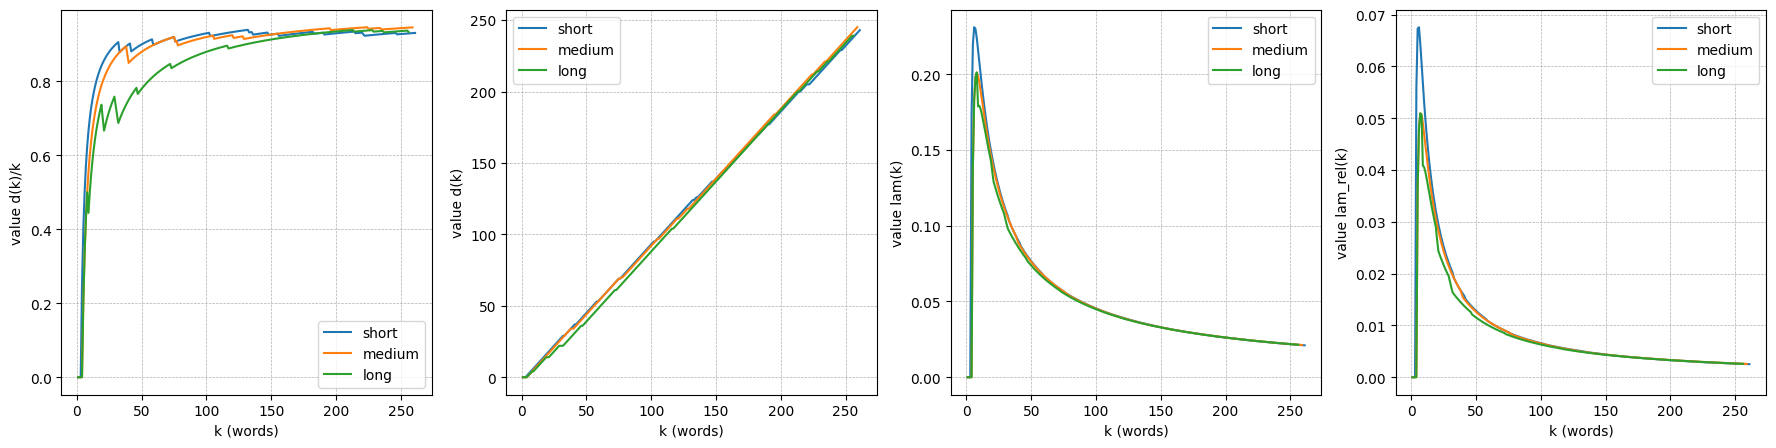

In [14]:
import math, re
import matplotlib.pyplot as plt

def tokenize_words(text: str):
    return re.findall(r"\b\w+\b", text.lower())

def levenshtein_prefix_series(a_words, b_words):
    K = min(len(a_words), len(b_words))
    a = a_words[:K]
    b = b_words[:K]
    D = [[0]*(K+1) for _ in range(K+1)]
    for i in range(1, K+1): 
        D[i][0] = i
    for j in range(1, K+1): 
        D[0][j] = j
    for i in range(1, K+1):
        ai = a[i-1]
        for j in range(1, K+1):
            cost = 0 if ai == b[j-1] else 1
            D[i][j] = min(D[i-1][j] + 1, D[i][j-1] + 1, D[i-1][j-1] + cost)
    return [D[k][k] for k in range(1, K+1)]

def effective_lyapunov(d_series):
    if not d_series:
        return []
    base = d_series[0] + 1
    lam = [math.log((d_series[k-1] + 1) / base) / k for k in range(1, len(d_series)+1)]
    return lam

def normalized_divergence(d_series):
    return [d / (k+1) for k, d in enumerate(d_series)]

def plot_metrics_for_size(size: str, completions: dict, seasons: list[str], axs):
    a_text = completions[size][seasons[0]]
    b_text = completions[size][seasons[1]]

    a_words = tokenize_words(a_text)
    b_words = tokenize_words(b_text)
    d = levenshtein_prefix_series(a_words, b_words)

    ks = list(range(1, len(d)+1))
    delta = [d_k / k for k, d_k in enumerate(d, start=1)]
    lam = [math.log(d_k + 1) / k for k, d_k in enumerate(d, start=1)]
    lam_rel = [math.log(d_k / k + 1) / k for k, d_k in enumerate(d, start=1)]

    axs[0].plot(ks, delta, label=size)
    axs[0].set_xlabel("k (words)"); 
    axs[0].set_ylabel("value d(k)/k")
    axs[0].grid(True, linestyle="--", linewidth=0.5)

    axs[1].plot(ks, d, label=size)
    axs[1].set_xlabel("k (words)"); 
    axs[1].set_ylabel("value d(k)")
    axs[1].grid(True, linestyle="--", linewidth=0.5)

    axs[2].plot(ks, lam, label=size)
    axs[2].set_xlabel("k (words)"); 
    axs[2].set_ylabel("value lam(k)")
    axs[2].grid(True, linestyle="--", linewidth=0.5)

    axs[3].plot(ks, lam_rel, label=size)
    axs[3].set_xlabel("k (words)"); 
    axs[3].set_ylabel("value lam_rel(k)")
    axs[3].grid(True, linestyle="--", linewidth=0.5)


fig, axs = plt.subplots(1, 4, figsize=(22, 5))
for size in sizes:
    plot_metrics_for_size(size, completions, seasons, axs)

for ax in axs:
    ax.legend()
plt.show()

### Podsumowanie

Jak widzimy, bardzo mała zmiana promptu (zmiana pory roku z `fall` na `summer`) bardzo wpływa na generowany tekst przez model. 
Warto zauwazyć, ze teksty generowałem w sposób deterministyczny, czyli model zawsze zwracał token o największym prawdopodobieństwie. 
Na wykresie drugim, widzimy, ze dokończenia rozjechały się praktycznie od razu (tylko pierwsze $<5$ słow jest podobnych) oraz rosną praktycznie liniowo,
co oznacza, ze słowa generowane dla podobnych promptów są całkowicie rózne.
Długość promptu, pomimo zmniejszenia procentu perturbacji w kontekście całego tekstu wejściowego, wcale nie stabilizuje trajektorii generowanego tekstu.
Prawdopodobnie wynika to z 

